## Experiments September

In [49]:
%matplotlib inline
import numpy
import os
import pandas
import pickle
import matplotlib.pyplot as plt

from sklearn import metrics

In [50]:
import seaborn
seaborn.set_style('white')

In [51]:
def get_auc_roc_curve(true, predicted):
    results = []
    ignored_sequences = 0
    for true_sequence, predicted_sequence in zip(true, predicted):
        try:
            results.append([metrics.roc_auc_score(true_sequence, predicted_sequence),
                            true_sequence.shape[0]])
        except ValueError:
            ignored_sequences += 1
    print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['AUC', 'Sequence lenght'])

def get_mean_auc_roc_curve(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.roc_auc_score(all_true, all_predicted)

In [52]:
def get_rmse(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5,
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['RMSE', 'Sequence lenght'])

def get_mean_rmse(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.mean_squared_error(all_true, all_predicted)**0.5

In [53]:
def get_r2(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.r2_score(true_sequence, predicted_sequence),
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['R2', 'Sequence lenght'])

def get_mean_r2(true, predicted):
    all_true = numpy.concatenate(true)
    all_predicted = numpy.concatenate(predicted)
    return metrics.r2_score(all_true, all_predicted)

In [54]:
def get_all_metrics(true, predicted):
    results = []
    ignored_sequences = 0
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([true_sequence.shape[0]])
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [55]:
def merge_sequences(metric_dataframes, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean ans std of metrics dataframes."""
    results = []
    for iteration, metric_dataframe in metric_dataframes.items():
        results.append([iteration[-20:]])
        for column in columns:
            results[-1].extend([metric_dataframe[column].mean(), metric_dataframe[column].std()])
    headers = numpy.concatenate([['Filename']] + [[column + '-mean', column + '-std'] for column in columns])
    return pandas.DataFrame(results, columns=headers)

In [56]:
def get_metrics_all_iterations(filenames):
    metric_dataframes = {}
    for filename in reversed(filenames):
        with open(filename, 'rb') as prediction_file:
            true, predicted = pickle.load(prediction_file)
            metric_dataframes[filename] = get_all_metrics(true, predicted)
    return metric_dataframes

In [57]:
def get_not_averaged_metrics(filenames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for filename in reversed(filenames):
        results.append([filename])
        with open(filename, 'rb') as prediction_file:
            true, predicted = pickle.load(prediction_file)
        
        # Flatten the sequences
        true_sequence = numpy.array([x for sequence in true for x in sequence])
        predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])

        results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Filename', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [58]:
def read_performances(filenames):
    results = {}
    for filename in reversed(filenames):
        with open(filename, 'rb') as performance_file:
            train, validation = pickle.load(performance_file)
        train = pandas.DataFrame(train, columns=['epoch', 'mse'])
        validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
        results[filename] = (train, validation) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(performances):
    dataframes = []
    for filename, (train, validation) in performances.items():
        train['Dataset'] = 'train'
        validation['Dataset'] = 'validation'
        dataframe = pandas.concat([train, validation], ignore_index=True)
        dataframe['Experiment'] = os.path.dirname(filename)[-14:]
        dataframes.append(dataframe)
    grid = seaborn.FacetGrid(data=pandas.concat(dataframes, ignore_index=True),
                             col='Experiment', despine=True, ylim=[0, 0.3], aspect=1.5,
                             col_wrap=min(3, len(dataframes)),
                             palette='colorblind')
    grid.map(seaborn.pointplot, 'epoch', 'mse', 'Dataset').add_legend()

# Basic DKT in Tensorflow

## Training curves

In [40]:
dkt_performance_filenames = [
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-34/performances.p',
]
dkt_train_performances = read_performances(dkt_performance_filenames)

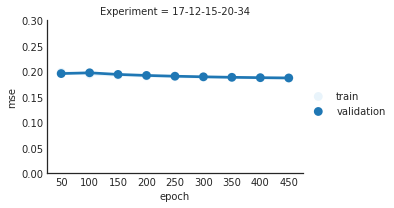

In [45]:
graphic_performances(dkt_train_performances)

## Performance metrics

In [60]:
DKT_FILENAMES = [
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-17-23/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-12/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/original/predictions/17-12-15-20-34/predictions.p',
]

In [61]:
merge_sequences(get_metrics_all_iterations(DKT_FILENAMES))

111 sequences with only one class, ignoring.
121 sequences with only one class, ignoring.
116 sequences with only one class, ignoring.


,Filename,AUC-mean,AUC-std,RMSE-mean,RMSE-std,APS-mean,APS-std,Accuracy-mean,Accuracy-std,R2-mean,R2-std
0,-20-34/predictions.p,0.651948,0.183274,0.405755,0.122376,0.823056,0.152688,0.729531,0.165634,-0.052425,0.350200
1,-20-12/predictions.p,0.668168,0.171874,0.396469,0.117491,0.833237,0.150080,0.741326,0.163091,-0.033497,0.354876
2,-17-23/predictions.p,0.674740,0.178008,0.392388,0.119748,0.840051,0.146093,0.750326,0.162456,-0.022723,0.379569


In [62]:
get_not_averaged_metrics(DKT_FILENAMES)

,Filename,AUC,RMSE,APS,Accuracy,R2
0,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.731531,0.436384,0.830381,0.714748,0.153422
1,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.746460,0.432091,0.837256,0.719583,0.176230
2,/home/mteruel/edm/results/dkt_lstm/original/pr...,0.744786,0.431707,0.835155,0.721327,0.176968


# DKT + Embedding layer

## Learning curves

In [35]:
embedded_performance_filenames = [
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-12-46/performances.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-13-37/performances.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-13-53/performances.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-22-34/performances.p',
]
embedded_train_performances = read_performances(embedded_performance_filenames)

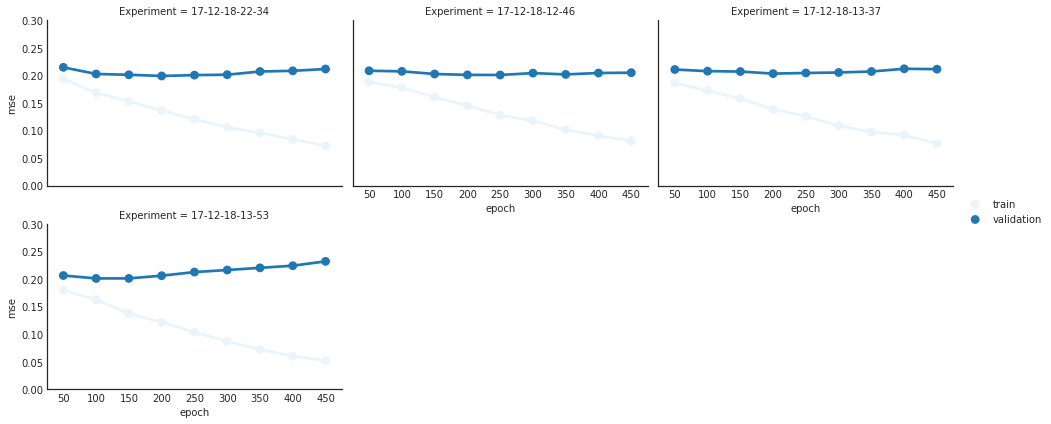

In [46]:
graphic_performances(embedded_train_performances)

## Generalized metrics

In [59]:
EMBEDDING_FILENAMES = [
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-12-46/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-13-37/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-13-53/predictions.p',
    '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-22-34/predictions.p',
]

In [60]:
merge_sequences(get_metrics_all_iterations(EMBEDDING_FILENAMES))

112 sequences with only one class, ignoring.
121 sequences with only one class, ignoring.
98 sequences with only one class, ignoring.
119 sequences with only one class, ignoring.


,Filename,AUC-mean,AUC-std,RMSE-mean,RMSE-std,APS-mean,APS-std,Accuracy-mean,Accuracy-std,R2-mean,R2-std
0,-13-53/predictions.p,0.688279,0.160496,0.439312,0.167823,0.846775,0.139089,0.714330,0.150101,-0.308212,0.825710
1,-22-34/predictions.p,0.692738,0.159817,0.431372,0.145433,0.841565,0.139558,0.718206,0.141786,-0.218737,0.563766
2,-12-46/predictions.p,0.694524,0.178614,0.421019,0.146068,0.849210,0.142790,0.709967,0.156545,-0.199744,0.605758
3,-13-37/predictions.p,0.695043,0.166712,0.426960,0.139255,0.840044,0.146867,0.709096,0.155689,-0.205758,0.637458


In [61]:
get_not_averaged_metrics(EMBEDDING_FILENAMES)

,Filename,AUC,RMSE,APS,Accuracy,R2
0,/home/mteruel/edm/results/dkt_lstm/embeddings/...,0.724222,0.464509,0.829982,0.702444,0.035671
1,/home/mteruel/edm/results/dkt_lstm/embeddings/...,0.724790,0.482506,0.826804,0.696119,-0.026500
2,/home/mteruel/edm/results/dkt_lstm/embeddings/...,0.722213,0.462102,0.824254,0.689405,0.062642
3,/home/mteruel/edm/results/dkt_lstm/embeddings/...,0.744299,0.447480,0.844621,0.709101,0.105748


## Detailed metrics

In [54]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/17-12-18-13-53/predictions.p'

with open(test_prediction_file, 'rb') as prediction_file:
    true, predicted = pickle.load(prediction_file)

In [55]:
get_mean_r2(true, predicted)

-0.026500260944488874

In [56]:
embedding_metrics = get_all_metrics(true, predicted)

121 sequences with only one class, ignoring.


In [57]:
embedding_metrics.describe()

,Sequence lenght,AUC,RMSE,APS,Accuracy,R2
count,800.000000,679.000000,800.000000,800.000000,800.000000,800.000000
mean,74.782500,0.688279,0.439312,0.846775,0.714330,-0.308212
std,148.809107,0.160496,0.167823,0.139089,0.150101,0.825710
min,1.000000,0.100000,0.000000,0.207569,0.250000,-13.575467
25%,8.000000,0.600000,0.405121,0.772442,0.613333,-0.444505
50%,22.000000,0.686224,0.481231,0.866080,0.700000,-0.171657
75%,73.250000,0.774237,0.537893,0.975207,0.795402,0.000000
max,1181.000000,1.000000,0.797918,1.000000,1.000000,1.000000


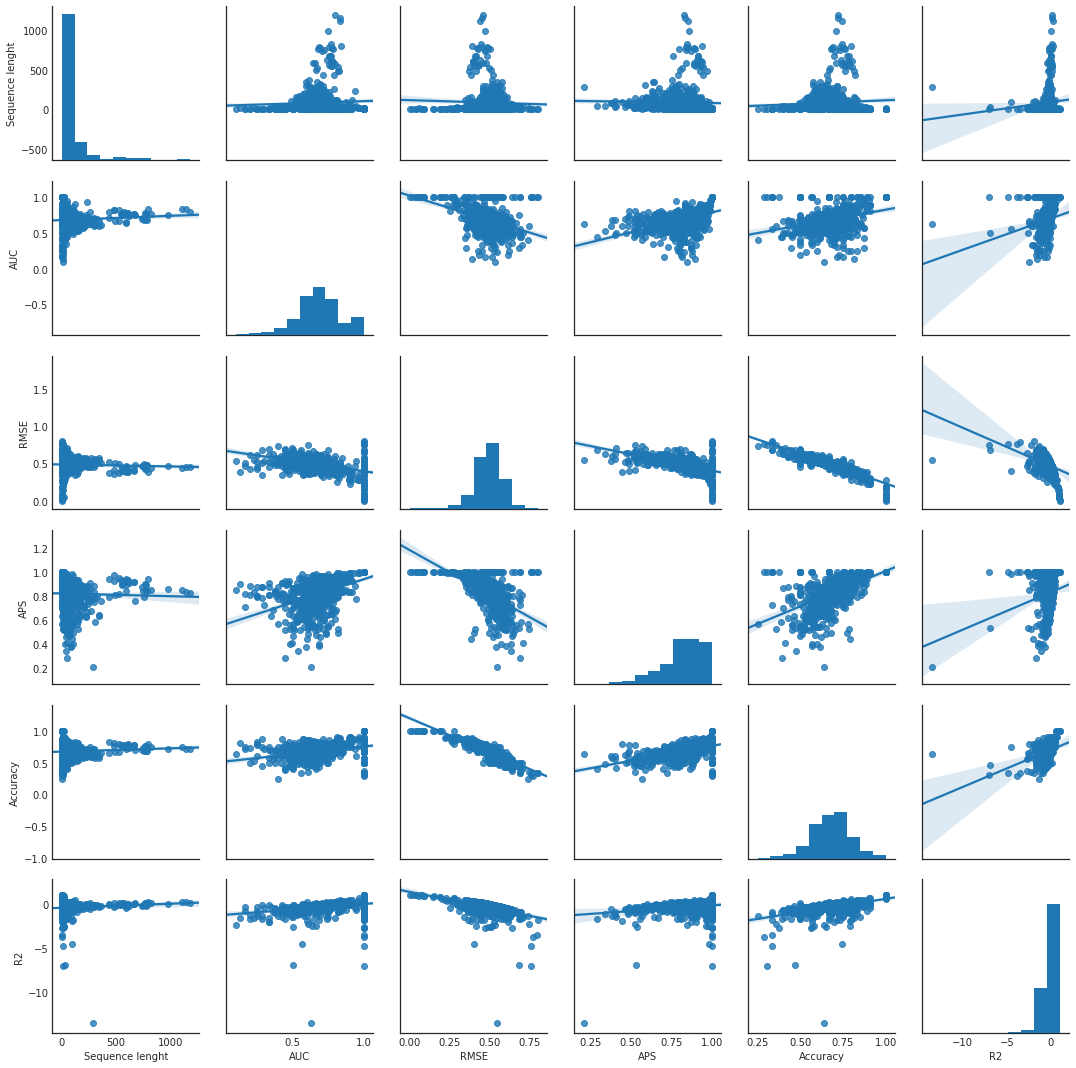

In [58]:
seaborn.pairplot(embedding_metrics[numpy.isfinite(embedding_metrics.AUC)], kind="reg")

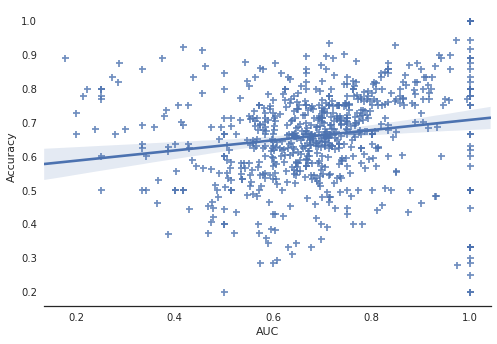

In [56]:
seaborn.regplot(x=embedding_metrics.AUC, y=embedding_metrics.Accuracy, marker="+")
seaborn.despine(left=True)

In [138]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/embeddings/predictions/test4/predictions.p'

with open(test_prediction_file, 'r') as prediction_file:
    true, predicted = pickle.load(prediction_file)

In [139]:
embedding_metrics = get_all_metrics(true, predicted)

116 sequences with only one class, ignoring.


In [140]:
embedding_metrics.describe()

,Sequence lenght,AUC,RMSE,APS,Accuracy,R2
count,800.000000,684.000000,800.000000,800.000000,800.000000,800.000000
mean,76.378750,0.679299,0.433110,0.839127,0.694538,-0.268894
std,159.096346,0.166399,0.139758,0.141409,0.156777,0.843659
min,1.000000,0.058824,0.000011,0.275591,0.200000,-13.684940
25%,9.000000,0.591498,0.397778,0.754409,0.600000,-0.353006
50%,20.000000,0.676142,0.464124,0.855330,0.672245,-0.093694
75%,64.250000,0.773253,0.514727,0.966657,0.777778,0.000000
max,1323.000000,1.000000,0.814888,1.000000,1.000000,0.989191


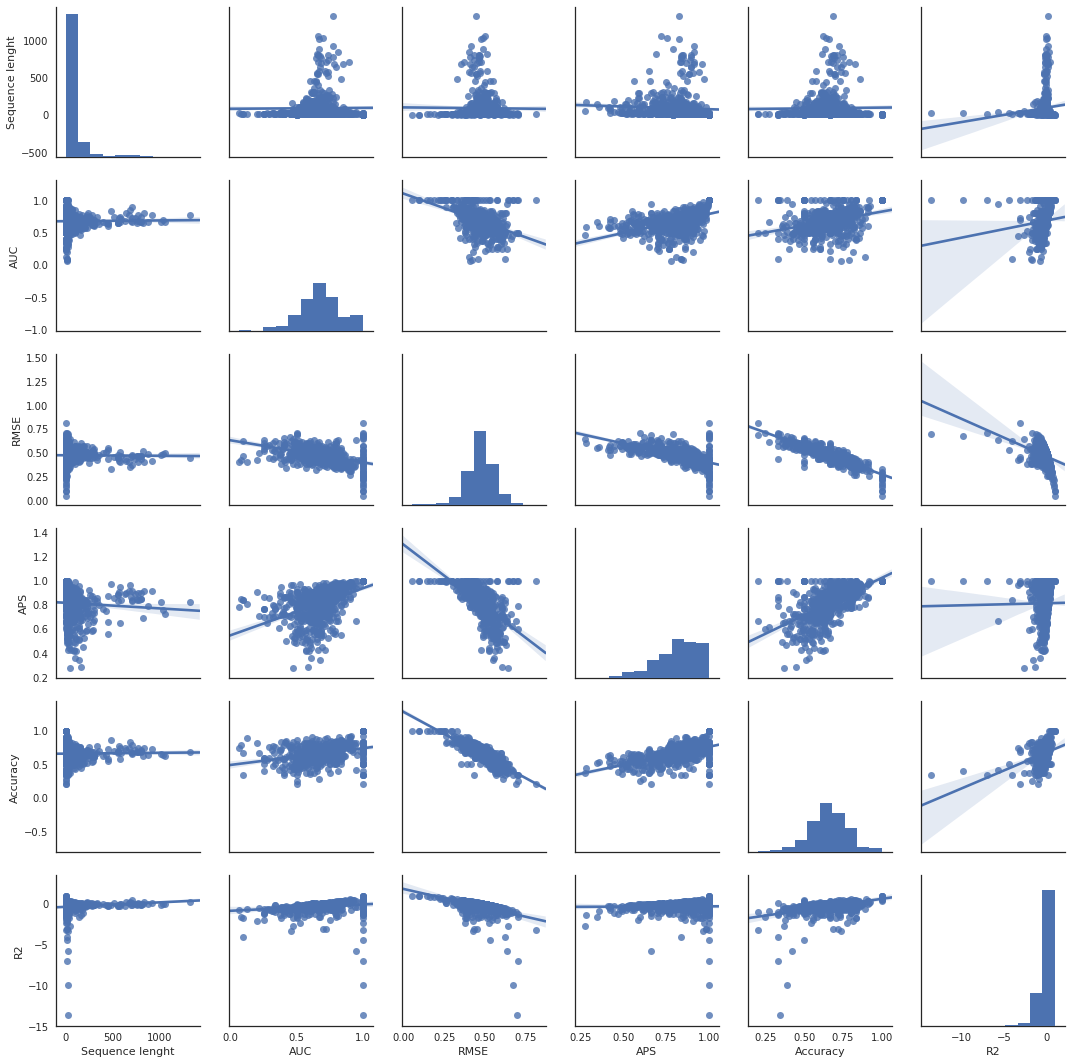

In [141]:
seaborn.pairplot(embedding_metrics[numpy.isfinite(embedding_metrics.AUC)], kind="reg")

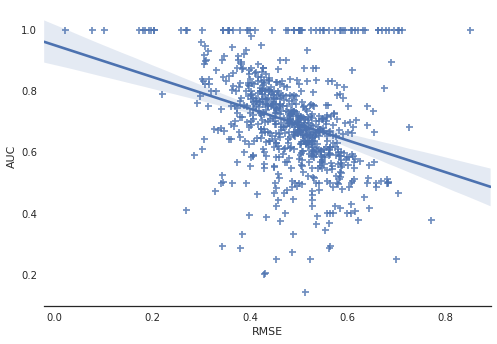

In [12]:
seaborn.regplot(x=embedding_metrics.RMSE, y=embedding_metrics.AUC, marker="+")
seaborn.despine(left=True)

In [144]:
metrics.mean_squared_error([3],[4.5])

2.25

# Metrics according to position in sequence

In [171]:
def get_all_position_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([index, abs(true_label - predicted_label), int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence position', 'MAE', 'Accuracy'])

In [172]:
position_metrics = get_all_position_metrics(true, predicted)

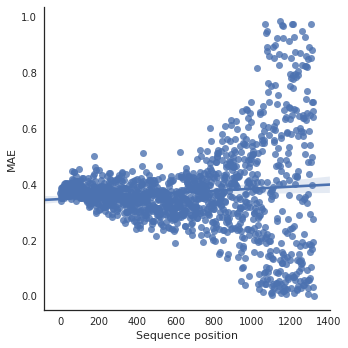

In [164]:
seaborn.lmplot(x='Sequence position', y='MAE', data=position_metrics.groupby('Sequence position').mean().reset_index())

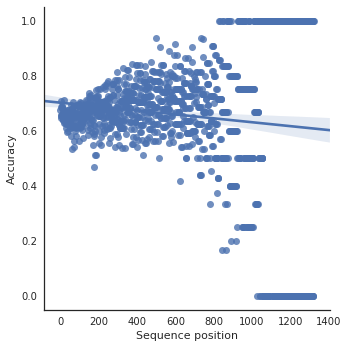

In [180]:
seaborn.lmplot(x='Sequence position', y='Accuracy', data=position_metrics.groupby('Sequence position').mean().reset_index())

In [196]:
def get_time_series_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for sequence_index, (true_sequence, predicted_sequence) in enumerate(zip(true, predicted)):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([sequence_index, index, abs(true_label - predicted_label), int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence', 'Time', 'MAE', 'Accuracy'])

In [199]:
time_series_metrics = get_time_series_metrics(true, predicted)

In [201]:
time_series_metrics[:20]

,Sequence,Time,MAE,Accuracy
0,0,0,0.096937,1
1,0,1,0.060708,1
2,0,2,0.011760,1
3,0,3,0.016215,1
4,0,4,0.614562,0
5,0,5,0.983609,0
6,0,6,0.849254,0
7,0,7,0.955141,0
8,0,8,0.034771,1
9,0,9,0.279300,1


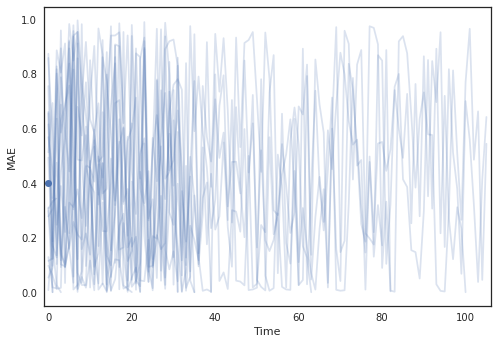

In [225]:
median_lenght = time_series_metrics.Time.median()
seaborn.tsplot(time="Time", value="MAE",
               unit="Sequence", data=time_series_metrics[time_series_metrics.Time < median_lenght][:1000],
               interpolate=False, err_style="unit_traces")

## Experiments with Co-embeddings